## CSC420: Detecting Cancerous Nuclei

In [ ]:
import tensorflow as tf
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.io import loadmat

from skimage.color import rgb2hed, rgb2gray
from skimage.feature import blob_dog

In [6]:
def load_img_data(index):
    imgf = 'Dataset/Detection/img{0}/img{0}.bmp'.format(index)
    detf = 'Dataset/Detection/img{0}/img{0}_detection.mat'.format(index)
    img = mpimg.imread(imgf)
    det = loadmat(detf)['detection']
    return img, det

## Load sample images

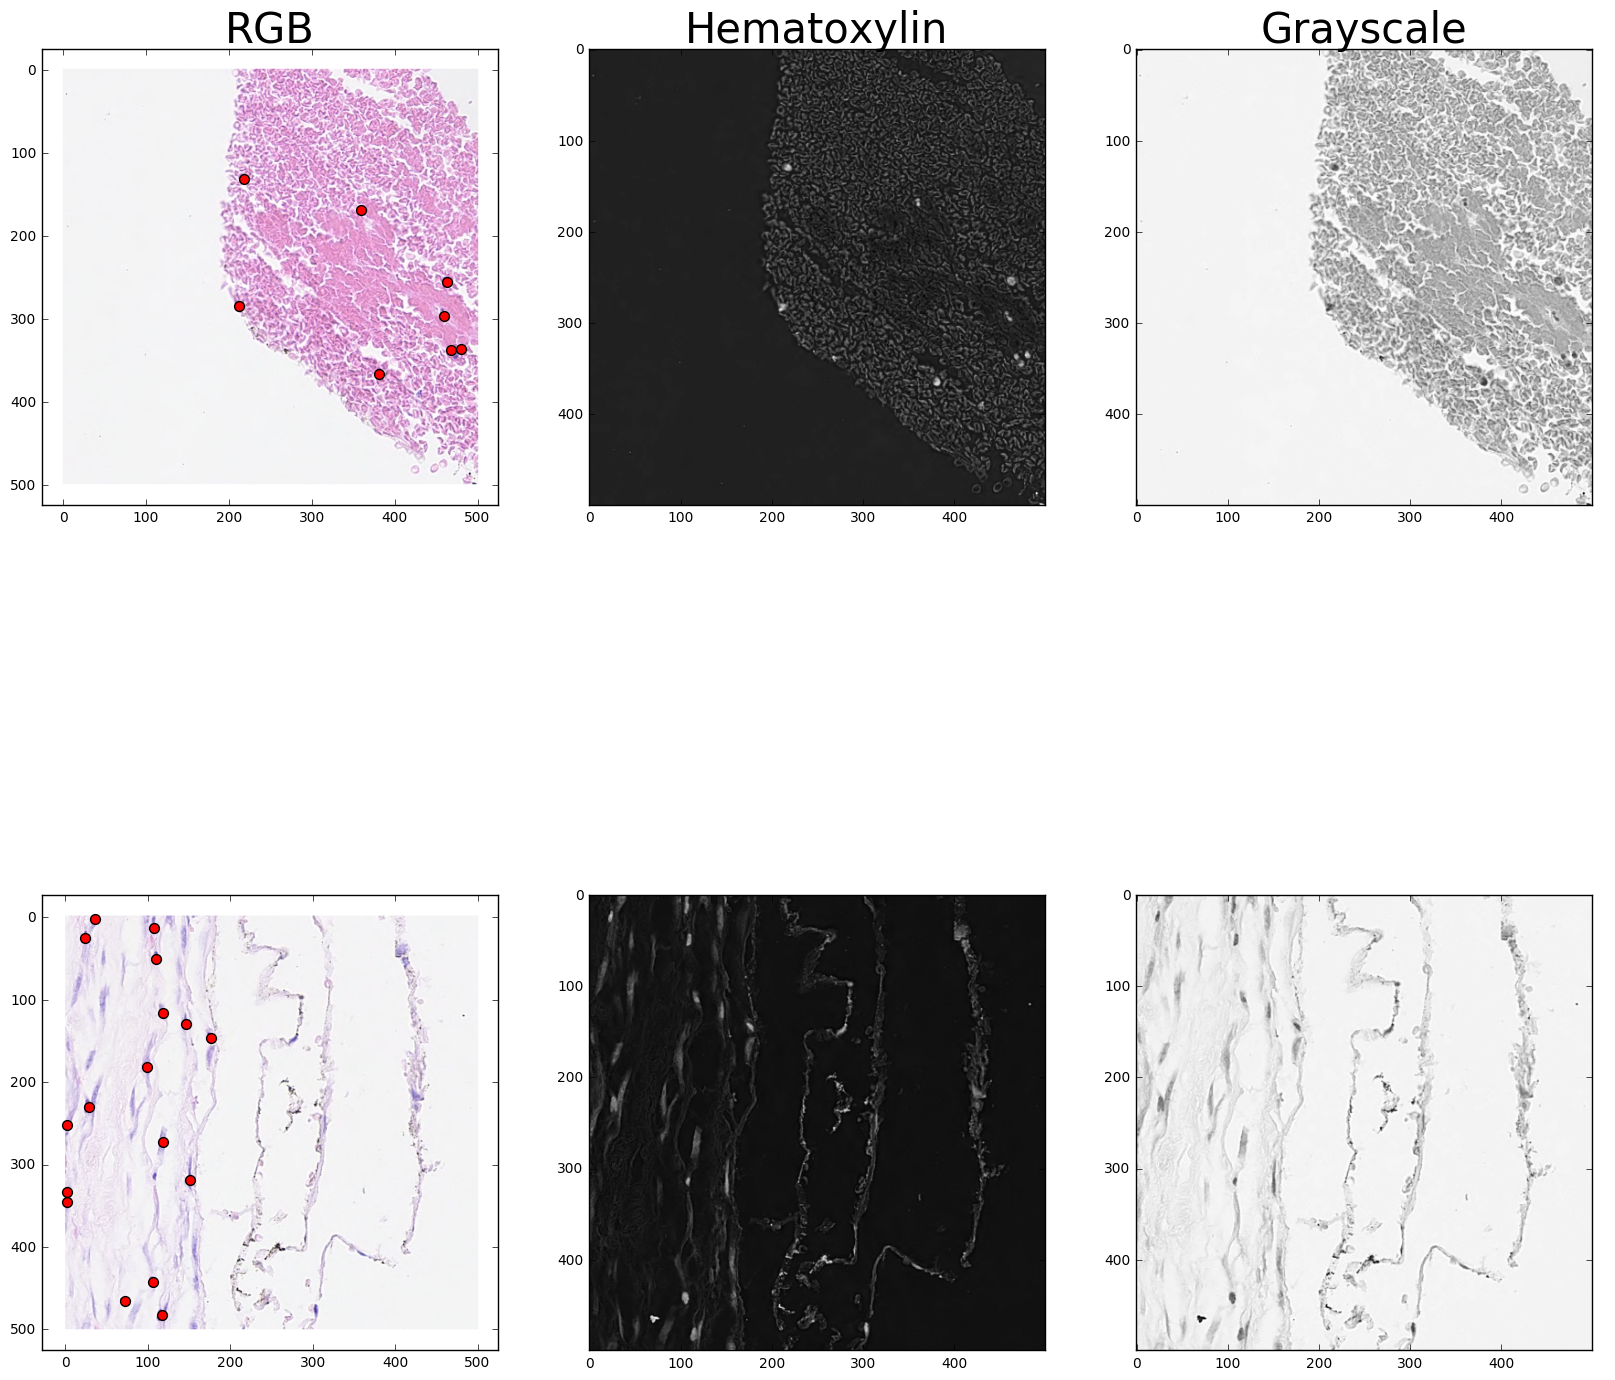

In [497]:
MY_TEST_IMG_GOOD = 74
MY_TEST_IMG_BAD = 73
img, dets = load_img_data(MY_TEST_IMG_GOOD)
img2, dets2 = load_img_data(MY_TEST_IMG_BAD)

plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(img)
plt.scatter(dets[:, 0], dets[:, 1], c='r', s=50)

plt.title("RGB", fontsize=30)
plt.subplot(232)
plt.imshow(rgb2hed(img)[:,:,0], cmap='gray')

plt.title("Hematoxylin", fontsize=30)
plt.subplot(233)
plt.imshow(rgb2gray(img), cmap='gray')
plt.title("Grayscale", fontsize=30)


plt.subplot(234)
plt.imshow(img2)
plt.scatter(dets2[:, 0], dets2[:, 1], c='r', s=50)

plt.subplot(235)
plt.imshow(rgb2hed(img2)[:,:,0], cmap='gray')

plt.subplot(236)
plt.imshow(rgb2gray(img2), cmap='gray')


## Zoom into a patch around labelled nuclei

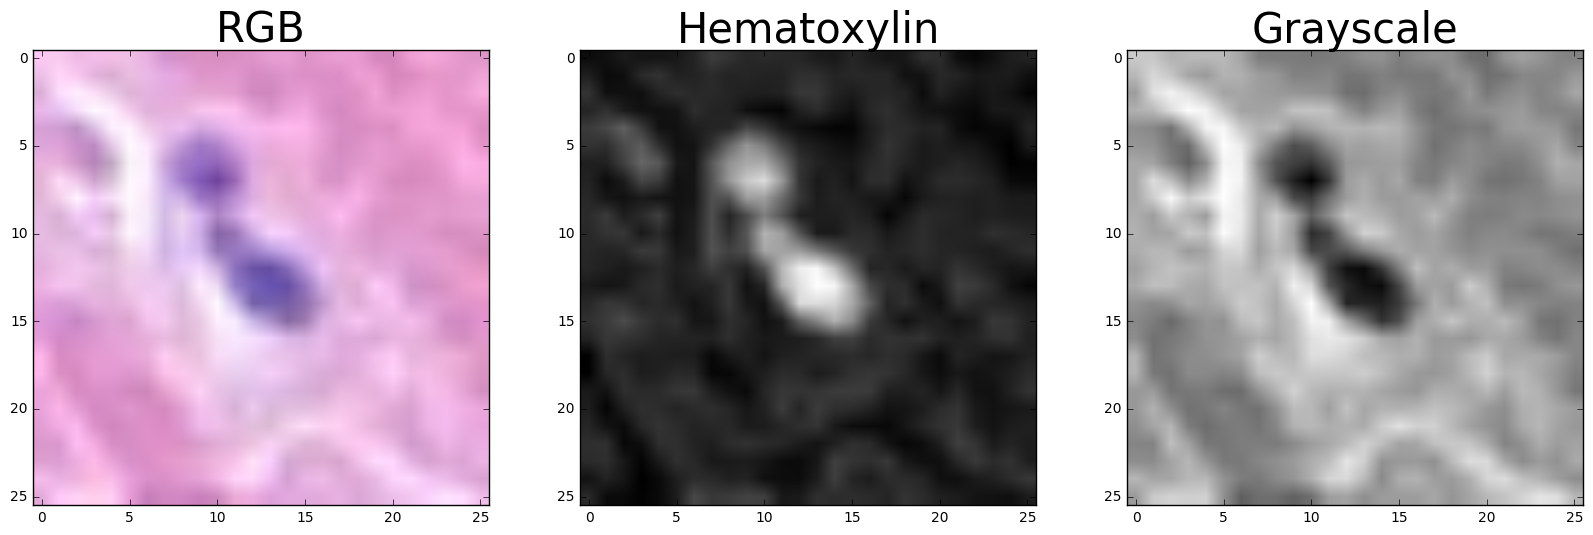

In [496]:
cell_index = np.random.randint(low=0, high=dets.shape[0])
det = dets[cell_index]
patch = img[det[1]-13:det[1]+13, det[0]-13:det[0]+13]

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(patch)
plt.title("RGB", fontsize=30)
plt.subplot(132)
plt.imshow(rgb2hed(patch)[:,:,0], cmap='gray')
plt.title("Hematoxylin", fontsize=30)
plt.subplot(133)
plt.imshow(rgb2gray(patch), cmap='gray')
plt.title("Grayscale", fontsize=30)

## Difference of Gaussian maximas for blob detection (regions of interest)

Dets [[212 284]
 [218 131]
 [360 169]
 [381 366]
 [460 296]
 [463 255]
 [468 338]
 [480 336]]
Blobs [[ 217.  130.]
 [ 359.  169.]
 [ 462.  254.]
 [ 211.  283.]
 [ 459.  294.]
 [ 268.  339.]
 [ 474.  340.]
 [ 380.  365.]
 [ 429.  391.]
 [ 494.  499.]]


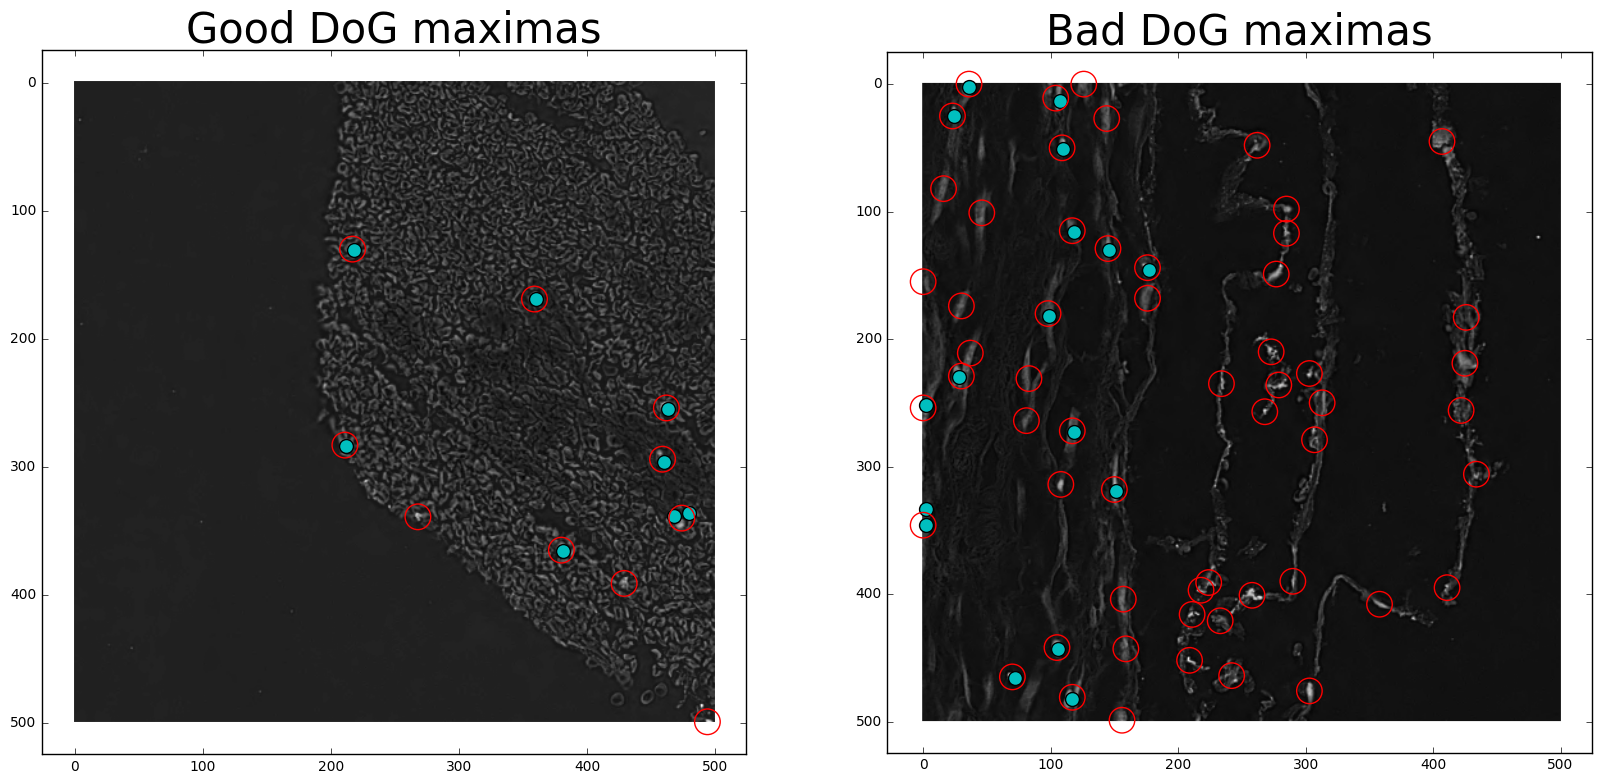

In [498]:
BLOB_MIN_SIG = 3
BLOB_MAX_SIG = 12
BLOB_THRES = 0.09

def get_blob_detections(img, blob_min_sig, 
                        blob_max_sig, blob_thres):    
    img_hed = skimage.color.rgb2hed(img)[:,:,0]
    blobs_dog = skimage.feature.blob_dog(img_hed, min_sigma=blob_min_sig, 
                                         max_sigma=blob_max_sig, threshold=blob_thres)
    return blobs_dog[:, [1,0]]

blobs = get_blob_detections(img, BLOB_MIN_SIG, BLOB_MAX_SIG, BLOB_THRES)
blobs2 = get_blob_detections(img2, BLOB_MIN_SIG, BLOB_MAX_SIG, BLOB_THRES)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(rgb2hed(img)[:, :, 0], cmap='gray')
fig = plt.gcf()
ax = fig.gca()
for x, y in blobs:
    c = plt.Circle((x, y), 10, color='r', linewidth=1, fill=False)        
    ax.add_artist(c)
plt.scatter(dets[:,0], dets[:,1], c='c', s=100)
plt.title('Good DoG maximas', fontsize=30)
print "Dets", dets
print "Blobs", blobs

plt.subplot(122)
plt.imshow(rgb2hed(img2)[:, :, 0], cmap='gray')
fig = plt.gcf()
ax = fig.gca()
for x, y in blobs2:
    c = plt.Circle((x, y), 10, color='r', linewidth=1, fill=False)        
    ax.add_artist(c)
plt.title('Bad DoG maximas', fontsize=30)
plt.scatter(dets2[:,0], dets2[:,1], c='c', s=100)

## Get a patch around DoG detected blob

/nfs/ug/groups/projects/scene-net/tf_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1605, 27, 27) (1605, 2)


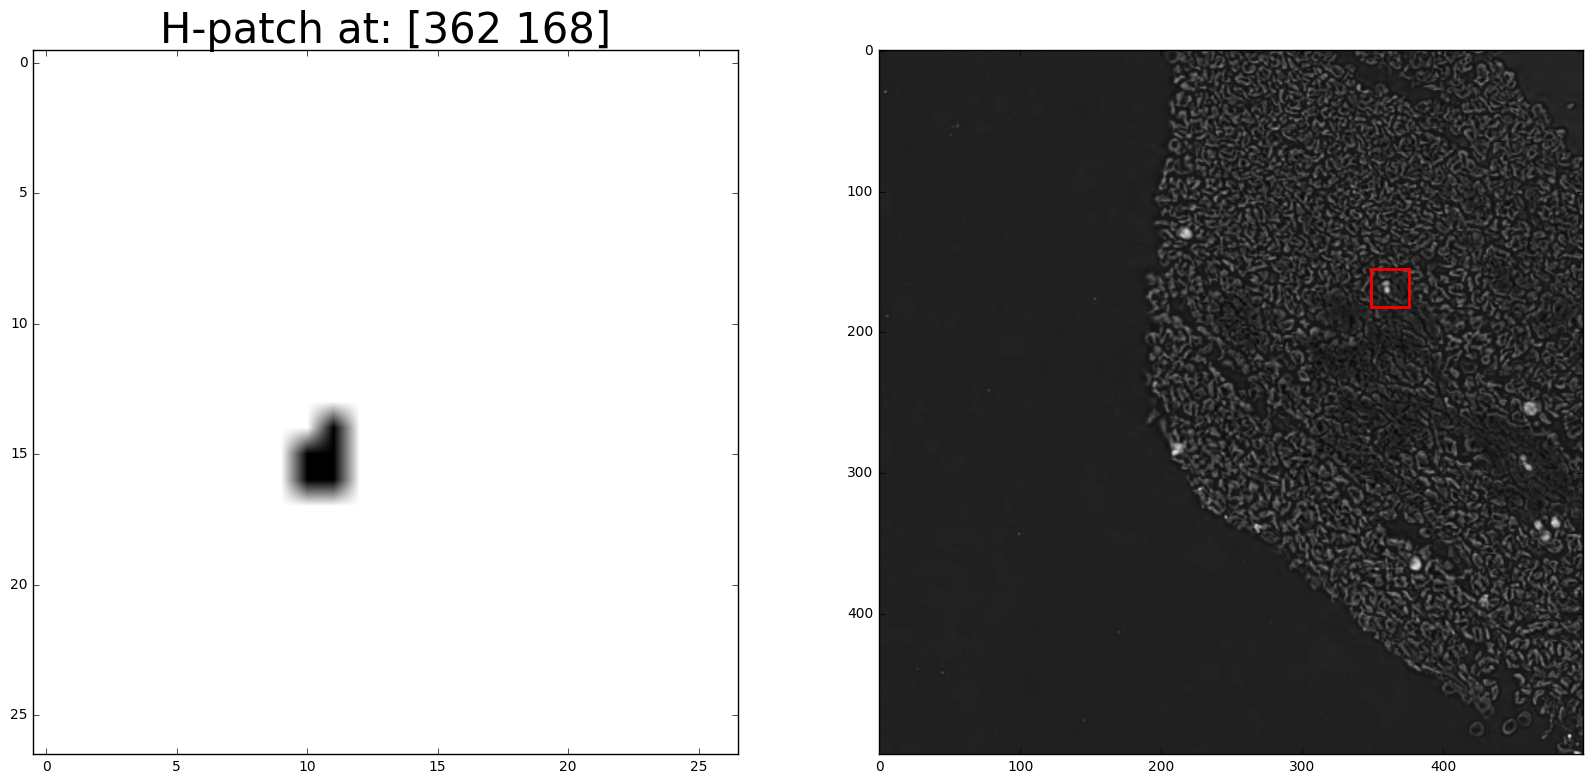

In [520]:
def get_blob_patches(img_id, 
                  deconv=False,
                  height=27, 
                  width=27, cell_rad=0):
    img, _ = load_img_data(img_id);
    blobs = get_blob_detections(img, BLOB_MIN_SIG, BLOB_MAX_SIG, BLOB_THRES)        
    
    dy = height/2
    dx = width/2
        
    # create a padded matrix of zeros to set to one for detected nuclei with radius cell_rad
    det = np.zeros((img.shape[0]+2*cell_rad, img.shape[1]+2*cell_rad), dtype=np.bool)
    for x, y in blobs:
        x += cell_rad
        y += cell_rad
        det[x-cell_rad:x+cell_rad+1, y-cell_rad:y+cell_rad+1] = 1
    
    det = det[cell_rad:-(cell_rad), cell_rad:-(cell_rad)] # crop out the padding
    patch_coords = np.array(np.nonzero(det)).T
    
    img = np.pad(img, ((dy+1,), (dx+1,), (0,)), 'symmetric')
            
    patches = []
    # pos eg
    for x,y in patch_coords:
        x += dy+1
        y += dx+1
        patch = img[y-dy:y+dy+1, x-dx:x+dx+1]
        if deconv:
            patch = rgb2hed(patch)[:,:,0]
        patches.append(patch)

    patches = np.stack(patches)
    return patches.astype(np.uint8), patch_coords.astype(np.uint16)

patches, centers = get_blob_patches(img_id=MY_TEST_IMG_GOOD, deconv=True, height=27, width=27, cell_rad=6)
print patches.shape, centers.shape
ind = np.random.randint(low=0, high=centers.shape[0])

plt.figure(figsize=(20,20))
plt.axis('off')
plt.subplot(121)
plt.imshow(patches[ind], cmap='gray')
plt.title('H-patch at: {:}'.format(centers[ind]), fontsize=30)

plt.subplot(122)
plt.imshow(rgb2hed(img)[:, :, 0], cmap='gray')
fig = plt.gcf()
ax = fig.gca()
x, y = centers[ind]
ax.add_patch(plt.Rectangle((x-13, y-13), 27, 27, ec='r', lw=2, fill=False))

## Get probability of nuclei centered in each patch using a CNN

In [511]:
try:
    sess.close()
except:
    pass

# Load the pretrained CNN model
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('detection_models/cp_cnn_model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint("detection_models/"))
g = tf.get_default_graph()
inference_tensor = g.get_tensor_by_name('detector_1/7_linear/BiasAdd:0')
patch_tensor = g.get_tensor_by_name('Placeholder:0')

Labelled [[212 284]
 [218 131]
 [360 169]
 [381 366]
 [460 296]
 [463 255]
 [468 338]
 [480 336]]


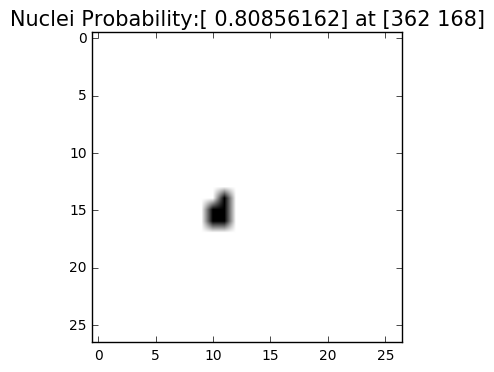

In [521]:
[predictions] = sess.run([inference_tensor], feed_dict={patch_tensor:np.expand_dims(patches, -1)})
plt.imshow(patches[ind], cmap='gray')
plt.title('Nuclei Probability:{:} at {:}'.format(predictions[ind], centers[ind]), fontsize=15)
print "Labelled", dets

## Good example

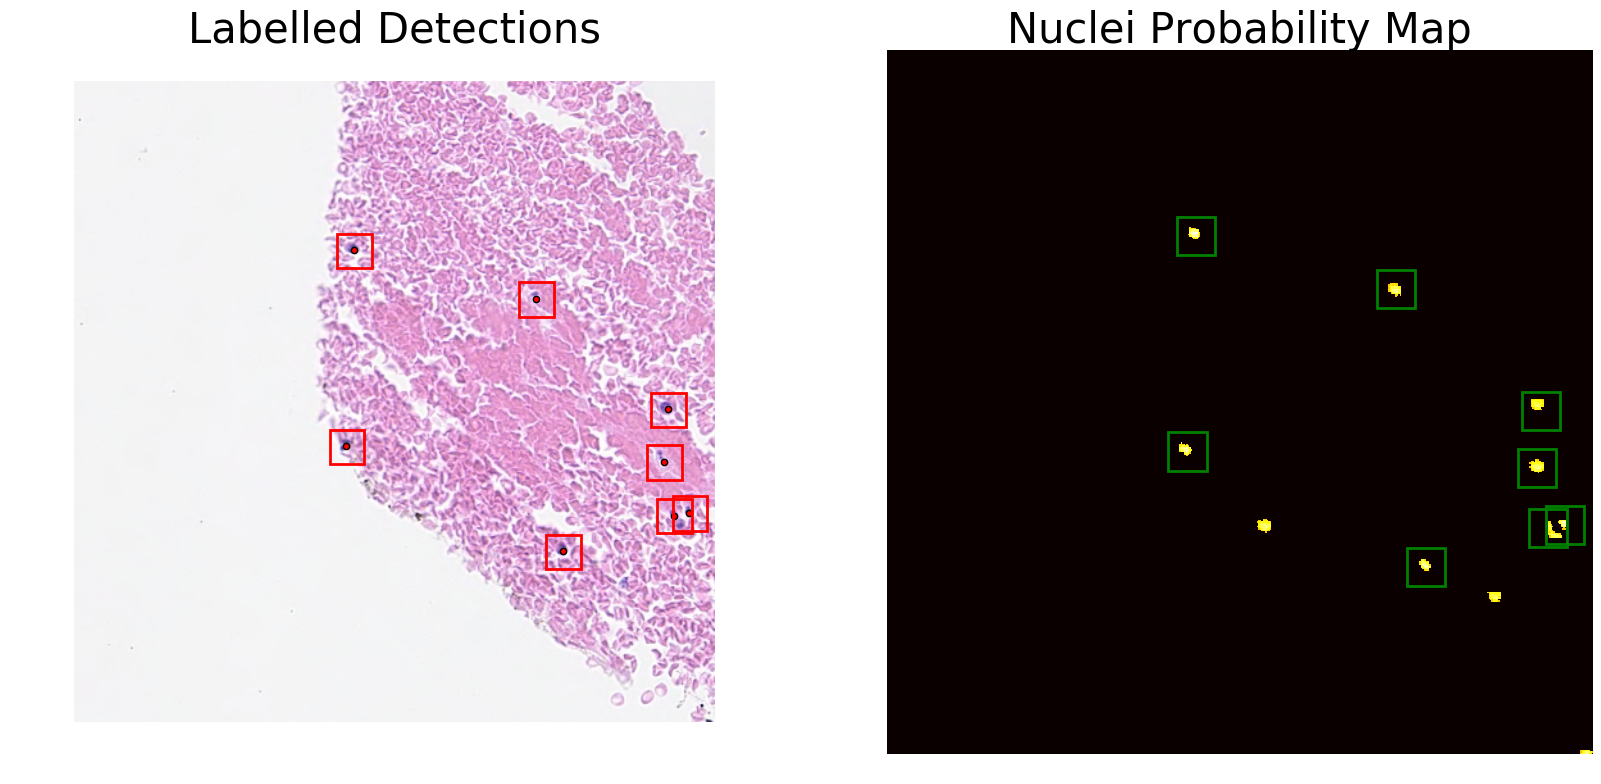

In [522]:
POS_THRESHOLD = 0.7

pred_img = np.zeros(img.shape[0:2], dtype=np.float)
for p in range(predictions.shape[0]):
    x, y = centers[p]
    pred_img[y, x] = predictions[p] if predictions[p] > POS_THRESHOLD else 0
    
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(img)
plt.scatter(dets[:, 0], dets[:, 1], c='r')
plt.axis('off')
plt.title("Labelled Detections", fontsize=30)
fig = plt.gcf()
ax = fig.gca()
for x, y in dets:
    ax.add_patch(plt.Rectangle((x-13, y-13), 27, 27, ec='r', lw=2, fill=False))        
plt.subplot(122)
plt.axis('off')
plt.title("Nuclei Probability Map", fontsize=30)
plt.imshow(pred_img, cmap='hot', interpolation='nearest')
fig = plt.gcf()
ax = fig.gca()
for x, y in dets:
    ax.add_patch(plt.Rectangle((x-13, y-13), 27, 27, ec='g', lw=2, fill=False))        

## Bad example

In [523]:
patches2, centers2 = get_blob_patches(img_id=MY_TEST_IMG_BAD, deconv=True, height=27, width=27, cell_rad=6)
[predictions2] = sess.run([inference_tensor], feed_dict={patch_tensor:np.expand_dims(patches2, -1)})

/nfs/ug/groups/projects/scene-net/tf_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


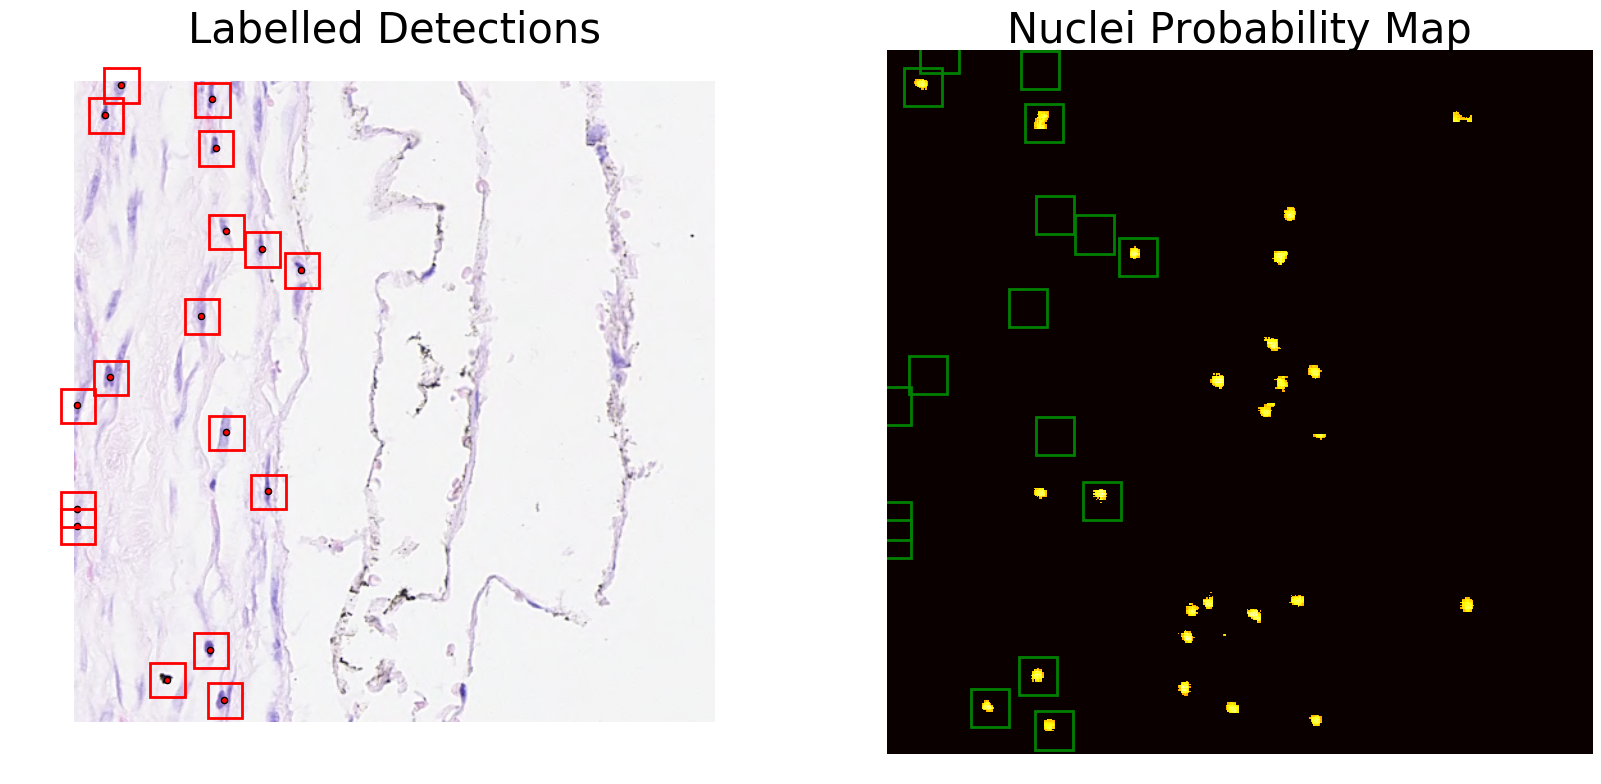

In [525]:
pred_img2 = np.zeros(img.shape[0:2], dtype=np.float)
for p in range(predictions2.shape[0]):
    x, y = centers2[p]
    pred_img2[y, x] = predictions2[p] if predictions2[p] > POS_THRESHOLD else 0
    
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(img2)
plt.scatter(dets2[:, 0], dets2[:, 1], c='r')
plt.axis('off')
plt.title("Labelled Detections", fontsize=30)
fig = plt.gcf()
ax = fig.gca()
for x, y in dets2:
    ax.add_patch(plt.Rectangle((x-13, y-13), 27, 27, ec='r', lw=2, fill=False))        
plt.subplot(122)
plt.axis('off')
plt.title("Nuclei Probability Map", fontsize=30)
plt.imshow(pred_img2, cmap='hot', interpolation='nearest')
fig = plt.gcf()
ax = fig.gca()
for x, y in dets2:
    ax.add_patch(plt.Rectangle((x-13, y-13), 27, 27, ec='g', lw=2, fill=False))        